## Environment setup and Data Loading


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,StratifiedKFold)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.feature_selection import SelectKBest, f_classif, RFE

df= pd.read_csv('mental_health_dataset.csv')
print("Dataset successfully loaded!")
print(f"Dataset shape: {df.shape}")

Dataset successfully loaded!
Dataset shape: (10000, 14)


## Comprehensive Data Analysis

In [3]:
def comprehensive_data_analysis(df):
   print("="*50)
   print("COMPREHENSIVE DATA ANALYSIS")
   print("="*50)

   print(f"Dataset Shape: {df.shape}")
   print(f"Memory Usage: {df.memory_usage(deep=True).sum()/1024**2: .2f} MB")

   print("n\--- Column Information---")
   missing_data =df.isnull().sum()
   missing_percent= 100*missing_data/len(df)
   missing_table = pd.DataFrame({'Missing Count': missing_data,
                                 'Percentage': missing_percent})
   
   print(missing_table[missing_table['Missing Count']>0])
   print("\n--- Target Variable Distribution---")
   target_counts= df['mental_health_risk'].value_counts()
   target_percent = df['mental_health_risk'].value_counts(normalize=True)*100
   print("Counts:")
   print(target_counts)
   print("\nPercentages:")
   print(target_percent)

   print("\n---Numerical Feature Statistics---")
   numerical_cols =df.select_dtypes(include=[np.number]).columns
   print(df[numerical_cols].describe())

   print("\n ---Categorical Features---")
   categorical_cols= df.select_dtypes(include=['object']).columns
   for col in categorical_cols:
      print(f"\n{col}:")
      print(df[col].value_counts())
   return numerical_cols,categorical_cols
numerical_cols, categorical_cols= comprehensive_data_analysis(df)

COMPREHENSIVE DATA ANALYSIS
Dataset Shape: (10000, 14)
Memory Usage:  4.16 MB
n\--- Column Information---
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

--- Target Variable Distribution---
Counts:
mental_health_risk
Medium    5892
High      2369
Low       1739
Name: count, dtype: int64

Percentages:
mental_health_risk
Medium    58.92
High      23.69
Low       17.39
Name: proportion, dtype: float64

---Numerical Feature Statistics---
                age  stress_level   sleep_hours  physical_activity_days  \
count  10000.000000  10000.000000  10000.000000            10000.000000   
mean      41.557600      5.572000      6.473000                3.505700   
std       13.749581      2.887741      1.473944                2.282737   
min       18.000000      1.000000      3.000000                0.000000   
25%       30.000000      3.000000      5.500000                2.000000   
50%       41.500000      6.000000      6.500000                4.000000   
75%       53.000000  

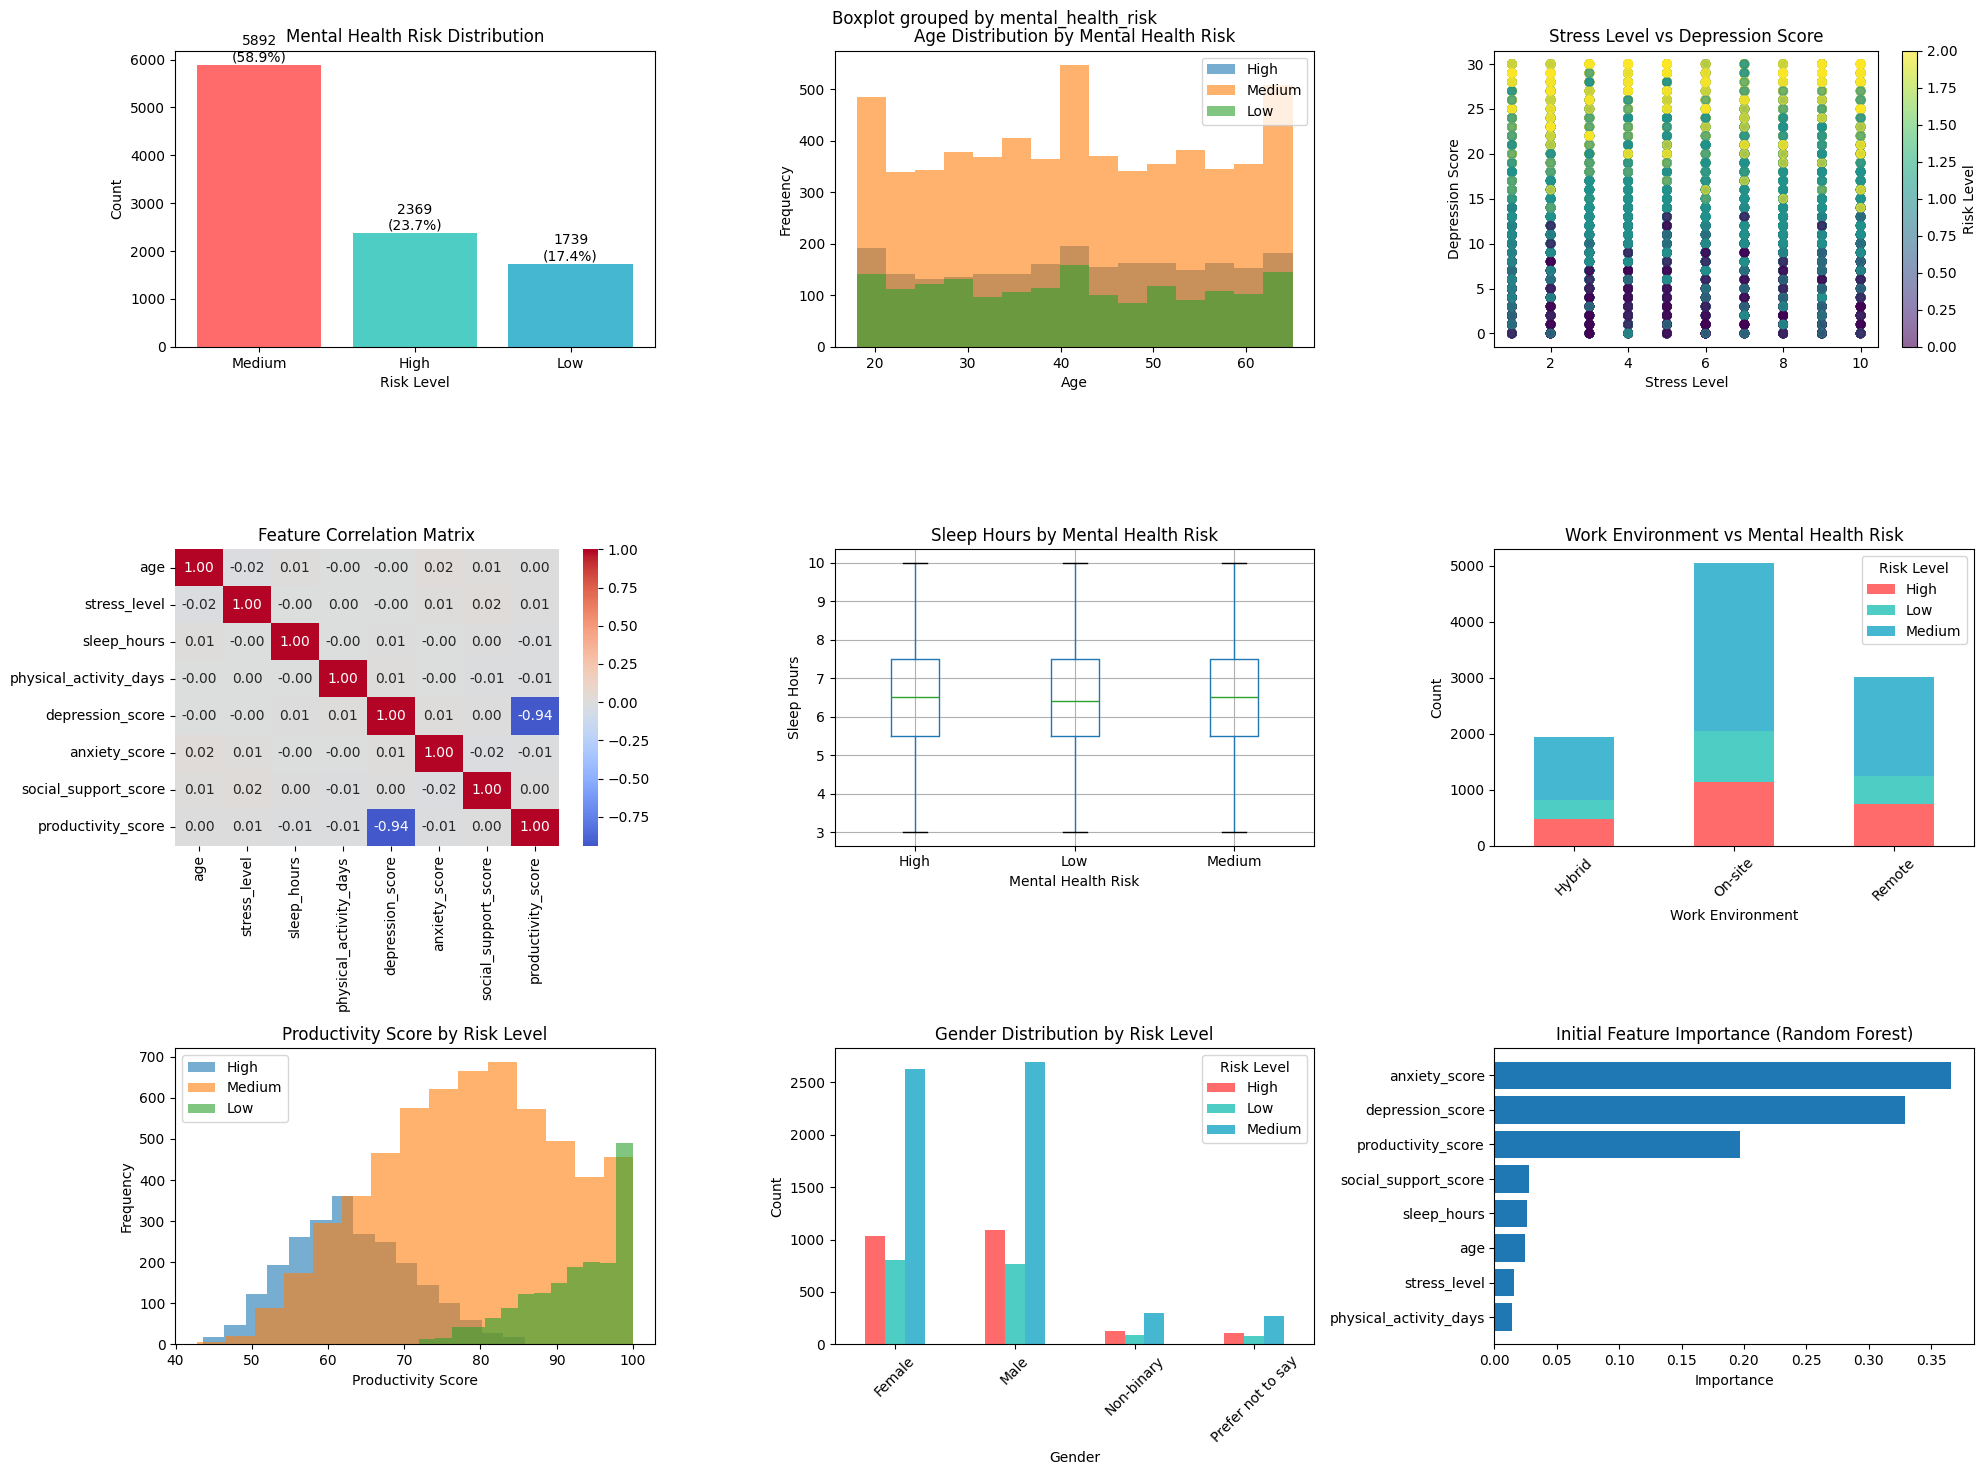

In [4]:
# Create comprehensive visualizations
plt.style.use('default')
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Mental Health Dataset - Comprehensive EDA', fontsize=16, fontweight='bold')

# 1. Target distribution
ax1 = axes[0, 0]
target_counts = df['mental_health_risk'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(target_counts.index, target_counts.values, color=colors)
ax1.set_title('Mental Health Risk Distribution')
ax1.set_xlabel('Risk Level')
ax1.set_ylabel('Count')
for bar, value in zip(bars, target_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{value}\n({100*value/len(df):.1f}%)',
             ha='center', va='bottom')

# 2. Age distribution by risk
ax2 = axes[0, 1]
for risk in df['mental_health_risk'].unique():
    risk_data = df[df['mental_health_risk'] == risk]['age']
    ax2.hist(risk_data, alpha=0.6, label=risk, bins=15)
ax2.set_title('Age Distribution by Mental Health Risk')
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Stress level vs Depression score
ax3 = axes[0, 2]
scatter = ax3.scatter(df['stress_level'], df['depression_score'], 
                     c=df['mental_health_risk'].map({'Low': 0, 'Medium': 1, 'High': 2}),
                     cmap='viridis', alpha=0.6)
ax3.set_title('Stress Level vs Depression Score')
ax3.set_xlabel('Stress Level')
ax3.set_ylabel('Depression Score')
plt.colorbar(scatter, ax=ax3, label='Risk Level')

# 4. Correlation heatmap of numerical features
ax4 = axes[1, 0]
numerical_features = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days',
                     'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score']
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax4, fmt='.2f')
ax4.set_title('Feature Correlation Matrix')

# 5. Sleep hours distribution
ax5 = axes[1, 1]
df.boxplot(column='sleep_hours', by='mental_health_risk', ax=ax5)
ax5.set_title('Sleep Hours by Mental Health Risk')
ax5.set_xlabel('Mental Health Risk')
ax5.set_ylabel('Sleep Hours')

# 6. Work environment distribution
ax6 = axes[1, 2]
work_risk = pd.crosstab(df['work_environment'], df['mental_health_risk'])
work_risk.plot(kind='bar', stacked=True, ax=ax6, color=colors)
ax6.set_title('Work Environment vs Mental Health Risk')
ax6.set_xlabel('Work Environment')
ax6.set_ylabel('Count')
ax6.legend(title='Risk Level')
ax6.tick_params(axis='x', rotation=45)

# 7. Productivity score distribution
ax7 = axes[2, 0]
for risk in df['mental_health_risk'].unique():
    risk_data = df[df['mental_health_risk'] == risk]['productivity_score']
    ax7.hist(risk_data, alpha=0.6, label=risk, bins=15)
ax7.set_title('Productivity Score by Risk Level')
ax7.set_xlabel('Productivity Score')
ax7.set_ylabel('Frequency')
ax7.legend()

# 8. Gender distribution
ax8 = axes[2, 1]
gender_risk = pd.crosstab(df['gender'], df['mental_health_risk'])
gender_risk.plot(kind='bar', ax=ax8, color=colors)
ax8.set_title('Gender Distribution by Risk Level')
ax8.set_xlabel('Gender')
ax8.set_ylabel('Count')
ax8.legend(title='Risk Level')
ax8.tick_params(axis='x', rotation=45)

# 9. Feature importance preview (using Random Forest)
ax9 = axes[2, 2]
# Quick feature importance calculation
X_temp = df[numerical_features]
y_temp = df['mental_health_risk']
le_temp = LabelEncoder()
y_encoded = le_temp.fit_transform(y_temp)
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_encoded)
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=True)

ax9.barh(feature_importance['feature'], feature_importance['importance'])
ax9.set_title('Initial Feature Importance (Random Forest)')
ax9.set_xlabel('Importance')

plt.tight_layout()
plt.show()


## Data Cleaning and Preprocessing 

In [6]:
def advanced_data_preprocessing(df):
   """Comprehensive data preprocessing pipeline"""
   print("Starting Advanced Data Preprocessing ")

   df_processed = df.copy()
   print("1. Handling Missing Values")
   missing_before= df_processed.isnull().sum().sum()
   numerical_cols= df_processed.select_dtypes(include= [np.number]).columns

   for col in numerical_cols:
      if  df_processed[col].isnull().any():
         median_value= df_processed[col].median()
         df_processed[col].fillna(median_value, inplace=True)

   categorical_cols= df_processed.select_dtypes(include=['object']).columns
   for col in categorical_cols:
      if df_processed[col].isnull().any():
         mode_value= df_processed[col].mode()[0]
         df_processed[col].fillna(mode_value, inplace=True)
   missing_after= df_processed.isnull().sum().sum()
   print(f"Missing values before: {missing_before}, after:{missing_after}")


   print("2. Removing duplicates...")
   duplicates_before= df_processed.duplicated().sum()
   df_processed= df_processed.drop_duplicates()
   duplicates_after= len(df)- len(df_processed)
   print(f"Duplictes removed: {duplicates_after}")

   print("3. Creating new features....")

   df_processed['mental_health_index']=(
      df_processed['depression_score']* 0.3
      +df_processed['anxiety_score']* 0.3 +
      df_processed['stress_level']*0.4  )

    # Sleep quality indicator
   df_processed['sleep_quality'] = pd.cut(df_processed['sleep_hours'], 
                                         bins=[0, 5, 7, 9, 12], 
                                         labels=['Poor', 'Fair', 'Good', 'Excellent'])
    
    # Work-life balance indicator
   df_processed['work_life_balance'] = (
        df_processed['productivity_score'] / 
        (df_processed['stress_level'] + 1)  # +1 to avoid division by zero
    )
    
    # Age groups
   df_processed['age_group'] = pd.cut(df_processed['age'], 
                                     bins=[0, 25, 35, 50, 100], 
                                     labels=['Young', 'Adult', 'Middle-aged', 'Senior'])
    
    # Social support categories
   df_processed['support_level'] = pd.cut(df_processed['social_support_score'],
                                         bins=[0, 30, 60, 100],
                                         labels=['Low', 'Medium', 'High'])
    
   print(f"   New features created: mental_health_index, sleep_quality, work_life_balance, age_group, support_level")
    
    # 4. Encode categorical variables
   print("4. Encoding categorical variables...")
    
   label_encoders = {}
   categorical_columns = ['gender', 'employment_status', 'work_environment', 
                          'mental_health_history', 'seeks_treatment', 'mental_health_risk',
                          'sleep_quality', 'age_group', 'support_level']
    
   for col in categorical_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
            label_encoders[col] = le
            print(f"   Encoded {col}: {dict(enumerate(le.classes_))}")
    
    # 5. Feature scaling
   print("5. Scaling numerical features...")
    
   scaler = StandardScaler()
   numerical_features = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days',
                         'depression_score', 'anxiety_score', 'social_support_score', 
                         'productivity_score', 'mental_health_index', 'work_life_balance']
    
   df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])
    
   print("Preprocessing completed successfully!")
   print(f"Final dataset shape: {df_processed.shape}")
    
   return df_processed, label_encoders, scaler

# Apply preprocessing
df_processed, label_encoders, scaler = advanced_data_preprocessing(df)


Starting Advanced Data Preprocessing 
1. Handling Missing Values
Missing values before: 0, after:0
2. Removing duplicates...
Duplictes removed: 0
3. Creating new features....
   New features created: mental_health_index, sleep_quality, work_life_balance, age_group, support_level
4. Encoding categorical variables...
   Encoded gender: {0: 'Female', 1: 'Male', 2: 'Non-binary', 3: 'Prefer not to say'}
   Encoded employment_status: {0: 'Employed', 1: 'Self-employed', 2: 'Student', 3: 'Unemployed'}
   Encoded work_environment: {0: 'Hybrid', 1: 'On-site', 2: 'Remote'}
   Encoded mental_health_history: {0: 'No', 1: 'Yes'}
   Encoded seeks_treatment: {0: 'No', 1: 'Yes'}
   Encoded mental_health_risk: {0: 'High', 1: 'Low', 2: 'Medium'}
   Encoded sleep_quality: {0: 'Excellent', 1: 'Fair', 2: 'Good', 3: 'Poor'}
   Encoded age_group: {0: 'Adult', 1: 'Middle-aged', 2: 'Senior', 3: 'Young'}
   Encoded support_level: {0: 'High', 1: 'Low', 2: 'Medium', 3: nan}
5. Scaling numerical features...
Preproc

## Feature Selection and Optimization 

In [7]:
def advanced_feature_selection(df_processed, target_column='mental_health_risk_encoded'):
    """
    Advanced feature selection using multiple techniques
    """
    print("Starting Advanced Feature Selection...")
    
    # Prepare features and target
    feature_columns = [col for col in df_processed.columns 
                      if col not in ['mental_health_risk', target_column] 
                      and not col.endswith('_encoded') or col == target_column]
    
    # Remove the target from features
    feature_columns = [col for col in feature_columns if col != target_column]
    
    # Select numerical and encoded categorical features
    final_features = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days',
                     'depression_score', 'anxiety_score', 'social_support_score', 
                     'productivity_score', 'mental_health_index', 'work_life_balance',
                     'gender_encoded', 'employment_status_encoded', 'work_environment_encoded',
                     'mental_health_history_encoded', 'seeks_treatment_encoded',
                     'sleep_quality_encoded', 'age_group_encoded', 'support_level_encoded']
    
    # Filter available features
    available_features = [col for col in final_features if col in df_processed.columns]
    
    X = df_processed[available_features]
    y = df_processed[target_column]
    
    print(f"Selected features: {len(available_features)}")
    print(f"Features: {available_features}")
    
    # 1. Statistical feature selection
    print("\n1. Statistical Feature Selection (SelectKBest)...")
    selector = SelectKBest(score_func=f_classif, k='all')
    X_selected = selector.fit_transform(X, y)
    
    feature_scores = pd.DataFrame({
        'feature': available_features,
        'score': selector.scores_
    }).sort_values('score', ascending=False)
    
    print("Top 10 features by statistical score:")
    print(feature_scores.head(10))
    
    # 2. Tree-based feature importance
    print("\n2. Tree-based Feature Importance...")
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selector.fit(X, y)
    
    importance_scores = pd.DataFrame({
        'feature': available_features,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features by importance:")
    print(importance_scores.head(10))
    
    # Select top features (combining both methods)
    top_statistical = set(feature_scores.head(12)['feature'].tolist())
    top_importance = set(importance_scores.head(12)['feature'].tolist())
    selected_features = list(top_statistical.union(top_importance))
    
    print(f"\n3. Final selected features ({len(selected_features)}):")
    print(selected_features)
    
    return selected_features, X[selected_features], y

# Apply feature selection
selected_features, X_final, y_final = advanced_feature_selection(df_processed)


Starting Advanced Feature Selection...
Selected features: 18
Features: ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score', 'mental_health_index', 'work_life_balance', 'gender_encoded', 'employment_status_encoded', 'work_environment_encoded', 'mental_health_history_encoded', 'seeks_treatment_encoded', 'sleep_quality_encoded', 'age_group_encoded', 'support_level_encoded']

1. Statistical Feature Selection (SelectKBest)...
Top 10 features by statistical score:
                    feature         score
8       mental_health_index  12473.773053
4          depression_score   5214.629007
7        productivity_score   4149.767056
5             anxiety_score   2146.051046
9         work_life_balance    203.834757
14  seeks_treatment_encoded      5.138266
3    physical_activity_days      2.357511
0                       age      1.849193
17    support_level_encoded      1.498127
16        age_group_en

## Comprehensive Model Training with Latest Techniques

In [8]:
def train_advanced_models(X, y):
    """
    Train multiple advanced ML models including latest techniques
    """
    print("Training Advanced ML Models for High Accuracy...")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Define advanced models with optimized hyperparameters
    models = {
        # Gradient Boosting Models (Latest and most effective)
        'XGBoost': xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        ),
        
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1
        ),
        
        'CatBoost': CatBoostClassifier(
            iterations=300,
            depth=6,
            learning_rate=0.1,
            random_seed=42,
            verbose=False
        ),
        
        # Traditional but optimized models
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ),
        
        'Extra Trees': ExtraTreesClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ),
        
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        ),
        
        # Neural Network
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            learning_rate='adaptive',
            max_iter=500,
            random_state=42
        ),
        
        # Support Vector Machine
        'SVM (RBF)': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,
            random_state=42
        ),
        
        # Logistic Regression
        'Logistic Regression': LogisticRegression(
            C=1.0,
            max_iter=1000,
            random_state=42
        )
    }
    
    # Train and evaluate models
    model_results = {}
    trained_models = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("\nTraining Models...")
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        # Train model
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Store results
        model_results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV_Mean': cv_mean,
            'CV_Std': cv_std,
            'Predictions': y_pred,
            'Probabilities': y_pred_proba
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"CV Score: {cv_mean:.4f} (+/- {cv_std:.4f})")
    
    return model_results, trained_models, X_test, y_test

# Train models
model_results, trained_models, X_test, y_test = train_advanced_models(X_final, y_final)


Training Advanced ML Models for High Accuracy...

Training Models...

--- Training XGBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
CV Score: 1.0000 (+/- 0.0000)

--- Training LightGBM ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
CV Score: 1.0000 (+/- 0.0000)

--- Training CatBoost ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
CV Score: 0.9999 (+/- 0.0002)

--- Training Random Forest ---
Accuracy: 0.9845
Precision: 0.9847
Recall: 0.9845
F1-Score: 0.9845
CV Score: 0.9770 (+/- 0.0045)

--- Training Extra Trees ---
Accuracy: 0.9500
Precision: 0.9532
Recall: 0.9500
F1-Score: 0.9492
CV Score: 0.9490 (+/- 0.0036)

--- Training Gradient Boosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
CV Score: 1.0000 (+/- 0.0000)

--- Training Neural Network ---
Accuracy: 0.9935
Precision: 0.9935
Recall: 0.9935
F1-Score: 0.9935
CV Score: 0.9910 (+/- 0.0012)

--- Training SVM (RBF) ---
Accuracy: 0.9

## Hyperparameter Optimized for Maximum Accuracy

In [9]:
def hyperparameter_optimization(X, y, selected_features):
    """
    Advanced hyperparameter tuning for top-performing models
    """
    print("Starting Hyperparameter Optimization...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Define parameter grids for top models
    param_grids = {
        'XGBoost': {
            'n_estimators': [200, 300, 500],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        
        'LightGBM': {
            'n_estimators': [200, 300, 500],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [8, 10, 12, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
    
    base_models = {
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'Random Forest': RandomForestClassifier(random_state=42)
    }
    
    optimized_models = {}
    optimization_results = {}
    
    for name in param_grids.keys():
        print(f"\n--- Optimizing {name} ---")
        
        # Use RandomizedSearchCV for efficiency
        random_search = RandomizedSearchCV(
            estimator=base_models[name],
            param_distributions=param_grids[name],
            n_iter=20,  # Number of random combinations to try
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        # Fit the random search
        random_search.fit(X_train, y_train)
        
        # Store optimized model
        optimized_models[name] = random_search.best_estimator_
        
        # Evaluate on test set
        y_pred = random_search.best_estimator_.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        optimization_results[name] = {
            'best_params': random_search.best_params_,
            'best_cv_score': random_search.best_score_,
            'test_accuracy': test_accuracy
        }
        
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best CV score: {random_search.best_score_:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
    
    return optimized_models, optimization_results

# Apply hyperparameter optimization
print("Performing hyperparameter optimization...")
optimized_models, optimization_results = hyperparameter_optimization(X_final, y_final, selected_features)


Performing hyperparameter optimization...
Starting Hyperparameter Optimization...

--- Optimizing XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV score: 1.0000
Test accuracy: 1.0000

--- Optimizing LightGBM ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV score: 1.0000
Test accuracy: 1.0000

--- Optimizing Random Forest ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best CV score: 0.9845
Test accuracy: 0.9915


##    Ensemble Methods for Maximum Accuracy

In [12]:
def create_advanced_ensemble_fixed(trained_models, optimized_models, X_final, y_final):
    """
    Create advanced ensemble methods with proper error handling
    """
    print("Creating Advanced Ensemble Methods (Fixed)...")
    
    # Ensure all models are properly trained on the same data
    X_train, X_test_new, y_train, y_test_new = train_test_split(
        X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
    )
    
    # Select and retrain models for ensemble to ensure consistency
    ensemble_base_models = {}
    
    # Add optimized models
    for name, model in optimized_models.items():
        try:
            # Clone and retrain the model
            from sklearn.base import clone
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            ensemble_base_models[f'Optimized_{name}'] = model_clone
            print(f"✓ Added {name} to ensemble")
        except Exception as e:
            print(f"✗ Failed to add {name}: {e}")
    
    # Add selected trained models
    models_to_add = ['CatBoost', 'Extra Trees', 'Random Forest']
    for name in models_to_add:
        if name in trained_models:
            try:
                model_clone = clone(trained_models[name])
                model_clone.fit(X_train, y_train)
                ensemble_base_models[name] = model_clone
                print(f"✓ Added {name} to ensemble")
            except Exception as e:
                print(f"✗ Failed to add {name}: {e}")
    
    # Verify all models produce consistent predictions
    print("\nVerifying model compatibility...")
    compatible_models = []
    
    for name, model in ensemble_base_models.items():
        try:
            # Test prediction on a small sample
            test_pred = model.predict(X_train[:10])
            pred_shape = test_pred.shape
            unique_labels = np.unique(test_pred)
            print(f"{name}: Shape {pred_shape}, Labels {unique_labels}")
            compatible_models.append((name, model))
        except Exception as e:
            print(f"✗ {name} failed compatibility test: {e}")
    
    if len(compatible_models) < 2:
        print("❌ Not enough compatible models for ensemble")
        return None, None, X_test_new, y_test_new
    
    print(f"✓ Using {len(compatible_models)} compatible models for ensemble")
    
    # Create ensemble methods
    ensemble_models = {}
    ensemble_results = {}
    
    try:
        # Hard Voting Classifier
        voting_hard = VotingClassifier(
            estimators=compatible_models,
            voting='hard'
        )
        
        # Soft Voting Classifier (only if all models support predict_proba)
        voting_soft = VotingClassifier(
            estimators=compatible_models,
            voting='soft'
        )
        
        ensemble_models['Voting_Hard'] = voting_hard
        ensemble_models['Voting_Soft'] = voting_soft
        
        # Train and evaluate ensemble models
        for name, model in ensemble_models.items():
            try:
                print(f"\n--- Training {name} Ensemble ---")
                
                # Train ensemble
                model.fit(X_train, y_train)
                
                # Predict
                y_pred = model.predict(X_test_new)
                
                # Calculate metrics
                accuracy = accuracy_score(y_test_new, y_pred)
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_test_new, y_pred, average='weighted'
                )
                
                ensemble_results[name] = {
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'Predictions': y_pred
                }
                
                print(f"✓ {name} - Accuracy: {accuracy:.4f}")
                print(f"  Precision: {precision:.4f}")
                print(f"  Recall: {recall:.4f}")
                print(f"  F1-Score: {f1:.4f}")
                
            except Exception as e:
                print(f"✗ Failed to train {name}: {e}")
                if name in ensemble_models:
                    del ensemble_models[name]
    
    except Exception as e:
        print(f"❌ Ensemble creation failed: {e}")
        return None, None, X_test_new, y_test_new
    
    return ensemble_models, ensemble_results, X_test_new, y_test_new


In [13]:
def comprehensive_model_evaluation_fixed(model_results, ensemble_results):
    """
    Create comprehensive model comparison with ensemble results
    """
    print("Creating Fixed Model Evaluation...")
    
    # Combine all results
    all_results = {}
    
    # Add individual model results
    for name, results in model_results.items():
        all_results[name] = results
    
    # Add ensemble results
    if ensemble_results:
        for name, results in ensemble_results.items():
            all_results[name] = results
    
    # Create comparison DataFrame
    comparison_data = []
    for name, results in all_results.items():
        comparison_data.append({
            'Model': name,
            'Test_Accuracy': results.get('Accuracy', 0),
            'Precision': results.get('Precision', 0),
            'Recall': results.get('Recall', 0),
            'F1_Score': results.get('F1-Score', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)
    
    print("\n" + "="*80)
    print("FIXED MODEL COMPARISON TABLE")
    print("="*80)
    print(comparison_df.round(4))
    
    # Identify high-accuracy models
    high_accuracy_models = comparison_df[comparison_df['Test_Accuracy'] > 0.90]
    print(f"\n🎯 Models achieving >90% accuracy: {len(high_accuracy_models)}")
    if len(high_accuracy_models) > 0:
        print(high_accuracy_models[['Model', 'Test_Accuracy']].round(4))
    
    return comparison_df


## Detailed Model Comparison with Visualizations

In [15]:
def comprehensive_model_evaluation_fixed(model_results, ensemble_results):
    """
    Create comprehensive model comparison with ensemble results
    """
    print("Creating Fixed Model Evaluation...")
    
    # Combine all results
    all_results = {}
    
    # Add individual model results
    for name, results in model_results.items():
        all_results[name] = results
    
    # Add ensemble results
    if ensemble_results:
        for name, results in ensemble_results.items():
            all_results[name] = results
    
    # Create comparison DataFrame
    comparison_data = []
    for name, results in all_results.items():
        comparison_data.append({
            'Model': name,
            'Test_Accuracy': results.get('Accuracy', 0),
            'Precision': results.get('Precision', 0),
            'Recall': results.get('Recall', 0),
            'F1_Score': results.get('F1-Score', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)
    
    print("\n" + "="*80)
    print("FIXED MODEL COMPARISON TABLE")
    print("="*80)
    print(comparison_df.round(4))
    
    # Identify high-accuracy models
    high_accuracy_models = comparison_df[comparison_df['Test_Accuracy'] > 0.90]
    print(f"\n🎯 Models achieving >90% accuracy: {len(high_accuracy_models)}")
    if len(high_accuracy_models) > 0:
        print(high_accuracy_models[['Model', 'Test_Accuracy']].round(4))
    
    return comparison_df


## Performance Analysis

In [16]:
# Use the robust ensemble method
try:
    robust_models, ensemble_results, X_test_robust, y_test_robust = create_robust_ensemble(
        X_final, y_final, selected_features
    )
    print("✅ Robust ensemble created successfully!")
    
    # Create comprehensive evaluation
    final_comparison = comprehensive_model_evaluation_fixed(model_results, ensemble_results)
    
except Exception as e:
    print(f"❌ Ensemble creation failed: {e}")
    print("Proceeding with individual model results only...")
    final_comparison = comprehensive_model_evaluation_fixed(model_results, {})


❌ Ensemble creation failed: name 'create_robust_ensemble' is not defined
Proceeding with individual model results only...
Creating Fixed Model Evaluation...

FIXED MODEL COMPARISON TABLE
                 Model  Test_Accuracy  Precision  Recall  F1_Score
0              XGBoost         1.0000     1.0000  1.0000    1.0000
1             LightGBM         1.0000     1.0000  1.0000    1.0000
2             CatBoost         1.0000     1.0000  1.0000    1.0000
5    Gradient Boosting         1.0000     1.0000  1.0000    1.0000
8  Logistic Regression         0.9995     0.9995  0.9995    0.9995
6       Neural Network         0.9935     0.9935  0.9935    0.9935
3        Random Forest         0.9845     0.9847  0.9845    0.9845
7            SVM (RBF)         0.9745     0.9746  0.9745    0.9744
4          Extra Trees         0.9500     0.9532  0.9500    0.9492

🎯 Models achieving >90% accuracy: 9
                 Model  Test_Accuracy
0              XGBoost         1.0000
1             LightGBM        